In [1]:
import glob as g
import ujson
import os
import os.path as op
import re
import subprocess as sp
from subprocess import CalledProcessError
import time
import ocrolib

In [77]:
def change_path(path, cat=None, ext=None, remove_type=False):
    """change catalog paths to a simpler folder structure"""
    norm = os.path.normpath(path)
    path_sep = norm.split(os.sep)
    filename = op.splitext(path_sep[-1])[0]
    # Throw away Filetype dir and filename
    if remove_type:
        path_sep = path_sep[:-2]
    else:
        del path_sep[-1]
    if cat:
        path_sep[-2] = cat
    if ext:
        path_sep.append(filename + ext)
    else:
        path_sep.append(filename)
    return op.sep.join(path_sep)

In [3]:
def convert_path(old,conversion):
    return {'path' : change_path(old['path'], **conversion)}

In [4]:
import pytest

def test_to_change_path():
    conv = {'cat': 'SD_png', 'ext': '.png', 'remove_type': True}
    png = change_path('../SD/SD002/TIF/00000643.tif',**conv)
    target = 'SD_png/SD002/00000643.png'.split(os.sep)
    assert png.split(os.sep)[-3:] == target
    
test_to_change_path()

In [5]:
def crop(inpath, outpath, right=0, bottom=70):
    cropargs = '-{}-{}'.format(right,bottom)
    p = ['convert', inpath, '-crop', cropargs, outpath]
    return p

In [6]:
def binarize(path):
    return ['ocropus-nlbin', '-t', '0.5', '-z', '1.0', path]
def segment(path):
    return ['ocropus-gpageseg', '--maxcolseps', '0', '--usegauss', '-z', '1.0', path]

In [7]:
def create_dirs(path):
    """create all directories for a given file path"""
    directory = op.split(path)[0]
    if not op.isdir(directory):
        os.makedirs(directory)
    return directory 

In [8]:
def echo(text):
    """create job that just prints text"""
    return ['echo', text]

In [9]:
def execute_job(process):
    """executes a subprocess and returns a dict with information about the execution"""
    e = None
    t_start = time.time()
    try:
        output = sp.check_output(process,stderr=sp.STDOUT)
    except CalledProcessError as e:
        output = e
    duration = time.time() - t_start
    return {'output': output, 'time':duration, 'complete': e is None}

In [71]:
def read_segments(path):
    path = path.encode()
    try:
        pseg = ocrolib.read_page_segmentation(path)
    except IOError as e:
        return []
    regions = ocrolib.RegionExtractor()
    regions.setPageLines(pseg)
    boxes = []
    for i in range(1,regions.length()):
        y0,x0,y1,x1  = regions.bboxMath(i)
        boxes.append((x0, y0,x1,y1))
    return boxes

In [83]:
CAT_NAME = 'SD'
CAT_CONV = 'SD_png'
DB_PATH  = 'data/convert.json'
N = 10

In [84]:

input_files = []
for path in g.glob('../{}/*/TIF/*'.format(CAT_NAME)):
    input_files.append({'path': path})
ujson.dump({'input_files': input_files}, open('data/convert.json','wb'), ensure_ascii=False)

In [85]:
db = ujson.load(open('data/convert.json'))

In [86]:
crop_conv = {'cat': 'SD_png', 'ext': '.png', 'remove_type': True}
seg_conv  = {'ext': '.pseg.png'}
bin_conv  = {'cat': 'SD_png', 'ext': '.bin.png'}
croppings = map(lambda old: {'from': old, 'to': convert_path(old,crop_conv)}, db['input_files'])
pngs      = map(lambda pair: pair['to'], croppings)
segmented = map(lambda croped: convert_path(croped, seg_conv), pngs)
binarized = map(lambda croped: convert_path(croped['to'], bin_conv), croppings)

crop_jobs = map(lambda conv: crop(conv['from']['path'],conv['to']['path']), croppings)
bin_jobs  = map(lambda png: binarize(png['path']), pngs)
seg_jobs  = map(lambda png: segment( png['path']), binarized)

In [87]:
created_dirs   = map(lambda conv: create_dirs(conv['to']['path']), croppings)
executions     = map(execute_job, crop_jobs)
bin_executions = map(execute_job, bin_jobs)
seg_executions = map(execute_job, seg_jobs)
pages          = map(lambda seg: read_segments(seg['path']), segmented)

KeyboardInterrupt: 

In [ ]:
times = [execution['time'] for execution in executions if execution['complete']]

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np

def vertices(x0, y0 ,x1,y1):
    return {'verts': 
            [(x0, y0),
            (x1, y0),
            (x1, y1), 
            (x0, y1),
            (x0, y0)],
            'codes':
            [Path.MOVETO,
             Path.LINETO,
             Path.LINETO,
             Path.LINETO,
             Path.CLOSEPOLY]}
def plot_lines(verts):
    return [v[0] for v in verts], [v[1] for v in verts]
shapes = map(lambda box: vertices(*box),boxes)

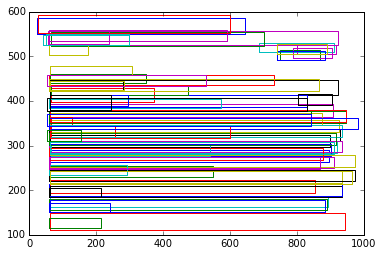

In [75]:
for page in pages:
    for shape in page:
        plt.plot(*plot_lines(vertices(*shape)['verts']))

In [76]:
seg_executions[3]

{'complete': True,
 'output': 'ERROR:  ../SD/SD_png/TIF/00000444.bin.png SKIPPED too many connnected components for a page image (1046 > 698) (use -n to disable this check)\nINFO:  \nINFO:  ########## /home/jakob/anaconda/bin/ocropus-gpageseg --maxcolseps 0 --u\nINFO:  \nINFO:  ../SD/SD_png/TIF/00000444.bin.png\n',
 'time': 0.4228789806365967}

In [89]:
len(executions)

10260